# A short excursion into training Deep Learning algorithms with applications to remote sensing

## Abstract

This notebook is not so much about doing code but rather about guiding you through understanding Deep Learning
in a way that you can approach training a given algorithm with the assurance that you compreehend what is 
going on. There are no silver bullets and a one-size-fits-all approaches.

The algorithm needs to fit your problem first. To do that you need to understand the data.  Only then you come into the training. This is where you turns the knobs in such way that you either validate or falsify your hypothesis when you selected the algorithm.

## Approaching the problem: a recipe

In the beginning there is the problem that you want to solve. Be it image classification, image super-resolution,
image augmentation, or analysing a physical phenomena represented in an image, like, for example a crop. Monitoring the crop health and even predicting the yield. The approach is always like this:

 1. Get familiar with the data. Correlate data from remote sensing with in field data.
 2. Choose a model selecting just a few of variables, e.g., humidity in the soil and an index like EVI or NDVI.
 3. One time setup of:
   + activation functions;
   + data preprocessing;
   + weight initialization;
   + regularization - to prevent overfitting.
 4. Training dynamics:
   + learning rate schedules;
   + large batch training;
   + hyper-parameter optimization.
 5. After training:
   + model ensembles;
   + transfer learning.
   
The choice of an algorithm (model) determines to a great extent what can be done in each step described above.

## A detour through universal approximation

A neural network can be understood as a mechanism to create a set of (hyper)parameters that are used in a representation of a given function. In fact there is a theorem that proves it. Familiarity with Functional Analysis and Function Spaces is required to follow such a [proof](https://link.springer.com/content/pdf/10.1007/s10472-020-09723-1.pdf). A _graphical proof_ can be found [here](http://neuralnetworksanddeeplearning.com/chap4.html).

Neural Networks are a way to derive approximations to functions that represent phenomena or features of the world we are interested in. The _magic_ of neural networks resides in the fact that these approximations can be derived by a computer just by feeding in the correct amount of data. If your problem is amenable to being mathematically modeled then you can inform the model by including specific information about this mathematical model into the structure of the network. This approach to machine learning is called [Scientific Machine Learning](https://www.scientific-ml.com).

The use of this physical model makes it so that training can be done with much less data, since we are already providing information in the form of the mathematical model.

The later could be relevant for applications like crop yield prediction, since crops can be [modeled](https://www.sciencedirect.com/science/article/pii/B9780444525123002333).

## Diving into our example

It would be impossible to do a full discussion with examples in the time we have. Instead we are going to dive into the code and show you on a practical example how we implemented a Sentinel 2 Super-resolution algorithm based on [Super-Resolution of Sentinel-2 Images: Learning a Globally Applicable Deep Neural Network](https://arxiv.org/abs/1803.04271). The resulting images are such that all bands are now at **10 m** resolution.

| Band Category | Spatial Resolution | Revisit |
|:---|:---|:---|
| Visible (4)          | 10 m | 5 days |
| Near-Infrared (6)    | 20 m | 5 days |
| Short-wave IR (3)    | 60 m | 5 days |


| Name | Resolution | Description |
|:---|:---:|:---|
| B01  | 60 m | Coastal aerosol, 442.7 nm (S2A), 442.2 nm (S2B)    |
| B02  | 10 m | Blue, 492.4 nm (S2A), 492.1 nm (S2B)               |
| B03  | 10 m | Green, 559.8 nm (S2A), 559.0 nm (S2B)              |
| B04  | 10 m | Red, 664.6 nm (S2A), 664.9 nm (S2B)                |
| B05  | 20 m | Vegetation red edge, 704.1 nm (S2A), 703.8 nm (S2B)|
| B06  | 20 m |	Vegetation red edge, 740.5 nm (S2A), 739.1 nm (S2B)|
| B07  | 20 m | Vegetation red edge, 782.8 nm (S2A), 779.7 nm (S2B)|
| B08  | 10 m | NIR, 832.8 nm (S2A), 832.9 nm (S2B)                |
| B8A  | 20 m | Narrow NIR, 864.7 nm (S2A), 864.0 nm (S2B)         |
| B09  | 60 m | Water vapour, 945.1 nm (S2A), 943.2 nm (S2B)       |
| B10  | 60 m | SWIR – Cirrus, 1373.5 nm (S2A), 1376.9 nm (S2B)    |
| B11  | 20 m | SWIR, 1613.7 nm (S2A), 442.2 nm (S2B)              |
| B12  | 20 m | SWIR, 2202.4 nm (S2A), 442.2 nm (S2B)              |

Although the exact application might differ from the one you have in mind, the way to approach the training process is the same. Some of the techniques used to do **data augmentation** might inspire you do to similarly in your problem.


### Model selection

The selected model is a [Residual Network](https://arxiv.org/abs/1512.03385) (ResNet). The network has multiple layers where the _initial_ layers performs feature extraction via convolutions with a 3x3 kernel. The layers that follow perform a (residual) scaling ($\lambda x$)  that regularizes the data. There is a skip connection from the input of the second layer to the output that is added to the output of the residual scaling.

Thinking in terms of function approximation, the residual layers with the skip connections function as an _almost_ identity function. This reduces the number of parameters in the model, allowing for deeper networks to be computationally approachable and also preempt overfitting of the model.

## Activation functions

The chosen activation function is the Rectified Linear Unit (ReLU).

$$f(x) = x^+ = \max(0, x)$$

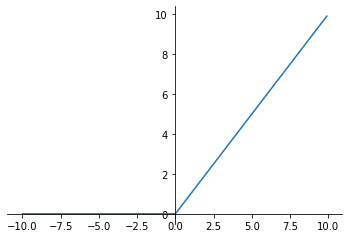

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the ReLu function.
relu = lambda x: max(0.0, x)

# Create the required array of values for the plot.
# Grid of 0.1 spacing from -10 to 10.
xvals = np.arange(-10, 10, 0.1)
yvals = np.array([relu(xi) for xi in xvals])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# Center the axes.
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Create line plot with yvals vs xvals.
plt.plot(xvals, yvals) 
plt.show()

### Data preprocessing

Starting from a small set (45) of Sentinel 2 full scenes in MTL ([SAFE](http://earth.esa.int/SAFE/)) format &mdash; one file per band, with rasters being provided in JPEG2000 format. The images in the bands with 10 and 20 m resolutions are **downsampled** to 20 and 40 m respectively. This technique of downsampling creates _synthetic_ images from the real ones.

The bands are collected according to their [Ground Sample Distance](https://en.wikipedia.org/wiki/Ground_sample_distance) (GSD) &mdash; informally _resolution &mdash; into three distinct sets:

$$ 
\begin{eqnarray}
A & = & (B2, B3, B4, B8)  &  \Leftarrow GSD = 10 m\\
B & = & (B5, B6, B7, B8a, B11, B12) &  \Leftarrow GSD = 20 m\\
C & = & (B1, B9) &  \Leftarrow GSD = 60 m
\end{eqnarray}
$$

Patches of 32x32 px for super-resolving $B$ to 10 m with information from $A$ and 96x96 px for super-resolving $C$ using information from $A$ and $B$. 

### Weight initialization

It uses the He Uniform Initializer, where the initial weights are computed from an uniform distribution related to the number of weights in the input. 

## Training Dynamics

Let us jump into the [code](https://github.com/up42/DSen2) and see the training procedure going in a Google Cloud Platform machine. The framework used is [TensorFlow](https://www.tensorflow.org/).

## How to improve this training procedure and, hopefully, the super-resolution algorithm

Here are some ideas for improvement:

 1. Instead of loading everything into memory we can **stream** the data. See [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). Thus enabling us to rely on a much smaller machine for training. 
 2. Instead of creating patches using custom code, take advantage of [tf.image.extract_patches](https://www.tensorflow.org/api_docs/python/tf/image/extract_patches). Also leverage the [raster tiling](https://marketplace.up42.com/block/3e146dd6-2b67-4d6e-a422-bb3d973e32ff) block.
 3. Structure the training process using [MFlow](https://mlflow.org).

## Resources

 1. [A recipe for training neural networks](https://karpathy.github.io/2019/04/25/recipe/): advice from an experienced practicioner.
 2. [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/index.html): a very thorough explanation of neural networks and the (simple) mathematics behind.
 3. [Image similarity measures](https://github.com/up42/image-similarity-measures).
 4. [Deep Learning for Computer Vision](https://web.eecs.umich.edu/~justincj/teaching/eecs498/FA2019/schedule.html): a very elaborate discussion of Deep Learning in the context of Computer Vision.